In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(suppress=True)

import sys
sys.path.append("../src")

from helpers import build_distance_matrix
from macro_models import batched_gaussian_process
from priors import diffusion_prior_gp, length_scale_prior
from micro_models import dynamic_batch_diffusion
from networks_10092022 import DynamicGaussianNetworkJoint
from context import generate_design_matrix

In [2]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [3]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical

In [4]:
from tqdm.notebook import tqdm
from functools import partial

# Constants

In [5]:
T = 3200
DIST_MAT = build_distance_matrix(T)
AMPLITUDES = [0.25, 0.25, 0.25, 0.25, 0.25, 0.15]
BATCH_SIZE = 3
TEST_SIZE = 10
EPOCHS = 100

2022-10-19 12:04:56.793062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 12:04:56.823018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 12:04:56.823185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 12:04:56.857139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
PARAMS_MEAN = [1.6, 1.6, 1.6, 1.6, 1.6, 0.5,
               10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
PARAMS_STD = [1.75, 1.75, 1.75, 1.75, 1.75, 0.6,
              5.7, 5.7, 5.7, 5.7, 5.7 , 5.7]

## Network

In [ ]:
def generator_fun(batch_size, T):
    theta = diffusion_prior(batch_size, n_cond=N_PARAMS-2)
    eta = random_walk_prior(batch_size, N_PARAMS)
    theta_t = random_walk(theta, eta, T)
    context = generate_design_matrix(batch_size, T)
    rt = dynamic_batch_diffusion(theta_t, context).astype(np.float32)
    x = tf.concat((rt, to_categorical(context[:, :, np.newaxis])), axis=-1)

    eta_z = scale_z(eta, MACRO_MEAN, MACRO_STD)
    
    theta_t_z = theta_t.copy()
    for i in range(theta_t.shape[0]):
        theta_t_z[i] =  scale_z(theta_t[i], MICRO_MEANS,  MICRO_STDS)

    return eta_z.astype(np.float32), theta_t_z.astype(np.float32), x

In [7]:
def generator_fun(batch_size):
    theta0 = diffusion_prior_gp(batch_size, n_cond=4)
    eta = length_scale_prior(batch_size, 6)
    eta_t = np.stack([eta] * T, axis=1)
    theta_t = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES).astype(np.float32)
    
    context = generate_design_matrix(batch_size, T)
    rt = dynamic_batch_diffusion(theta_t, context).astype(np.float32)
    x = tf.concat((rt, to_categorical(context[:, :, np.newaxis])), axis=-1)
    
    params_t = np.concatenate([theta_t, eta_t], axis=-1)
    params_t_z = (params_t - PARAMS_MEAN) / PARAMS_STD
    

    return params_t_z, x

In [54]:
params_t_z, x = generator_fun(1)
params_t_z.shape

(1, 3200, 12)

In [8]:
# theta0 = diffusion_prior_gp(TRAIN_SIZE, n_cond=1)
# eta = length_scale_prior(TRAIN_SIZE, 3).astype(np.float32)
# theta_t = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES).astype(np.float32)
# eta_t = np.stack([eta] * T, axis=1)
# rt = simple_batch_diffusion(theta_t).astype(np.float32)
# params_t = np.concatenate([theta_t, eta_t], axis=-1)
# dataset = tf.data.Dataset.from_tensor_slices((rt, params_t)).shuffle(1024).batch(BATCH_SIZE)

In [9]:
network_settings = {
    'embedding_lstm_units' : 128, 
    'embedding_gru_units': 128,
    'embedding_dense_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'),
    'posterior_dense_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'),
    'n_micro_params': 6,
    'n_macro_params': 6
}
network = DynamicGaussianNetworkJoint(network_settings)

In [10]:
simulator = partial(generator_fun, batch_size=BATCH_SIZE)
steps_per_epoch = 500
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=2500,
    decay_rate=0.8,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [11]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

In [12]:
def epoch_trainer(generator, network, optimizer, steps_per_epoch, p_bar):
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
            
            # Simulate from model
            params_t_z, data = generator() 

            # Forward pass
            posterior = network(data)

            # loss computation
            loss = nll(params_t_z, posterior)
        
        # One step backprop
        g = tape.gradient(loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss: {:.3f},Loss.Avg: {:.3f}"
                              .format(ep, step, loss.numpy(), np.mean(losses)))
        p_bar.update(1)
    return losses

In [13]:
# def train_epoch(network, optimizer, dataset, batch_size, p_bar, mmd_weight=0.1):
#     """ Helper function for one simulation epoch. """
    
#     losses = []
#     for bi, (data, params) in enumerate(dataset):
#         with tf.GradientTape() as tape:
#             params_pred = network(data)
#             params_z = (params - params_mean) / params_std
#             loss = nll(params_z, params_pred)
            
#         # Backprop step
#         g = tape.gradient(loss, network.trainable_variables)
#         optimizer.apply_gradients(zip(g, network.trainable_variables))
#         losses.append(loss.numpy())

#         # Update progress bar
#         p_bar.set_postfix_str("Batch {},Loss: {:.3f},Avg.Loss: {:.3f}"
#                               .format(bi+1, loss.numpy() , np.mean(losses)))
#         p_bar.update(1)
#     return losses

In [14]:
# Train
losses = []
for ep in range(1, EPOCHS+1):
    with tqdm(total=steps_per_epoch, desc=f'Training Epoch {ep}') as p_bar:
        loss_ep = epoch_trainer(simulator, network, optimizer, steps_per_epoch, p_bar)
        losses.append(loss_ep)
    network.save_weights('../trained_networks/gp_ddm_3200_joint')

Training Epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

2022-10-19 12:05:05.270729: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


Training Epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 11:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 12:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 13:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 14:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 15:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 16:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 17:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 18:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 19:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 20:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 21:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 22:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 23:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 24:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 25:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 26:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 27:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 28:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 29:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 30:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 31:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 32:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 33:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 34:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 35:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 36:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 37:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 38:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 39:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 40:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 41:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 42:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 43:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 44:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 45:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 46:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 47:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 48:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 49:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 50:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epoch 51:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Validation

## Gen Test Data

In [ ]:
# theta0 = diffusion_prior_gp(TEST_SIZE, n_cond=1)
# eta = length_scale_prior(TEST_SIZE, 3)
# theta_test = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES)
# rt_test = simple_batch_diffusion(theta_test).astype(np.float32)

In [57]:
theta0 = diffusion_prior_gp(TEST_SIZE, n_cond=4)
eta = length_scale_prior(TEST_SIZE, 6)
theta_test = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES).astype(np.float32)

context = generate_design_matrix(TEST_SIZE, T)
rt_test = dynamic_batch_diffusion(theta_test, context).astype(np.float32)
x_test = tf.concat((rt_test, to_categorical(context[:, :, np.newaxis])), axis=-1)

## Predict

In [52]:
theta_preds = network(x_test)
theta_means = theta_preds.mean() * PARAMS_STD + PARAMS_MEAN
theta_stds = theta_preds.stddev() * PARAMS_STD

##  Visualize Predictions Over Time

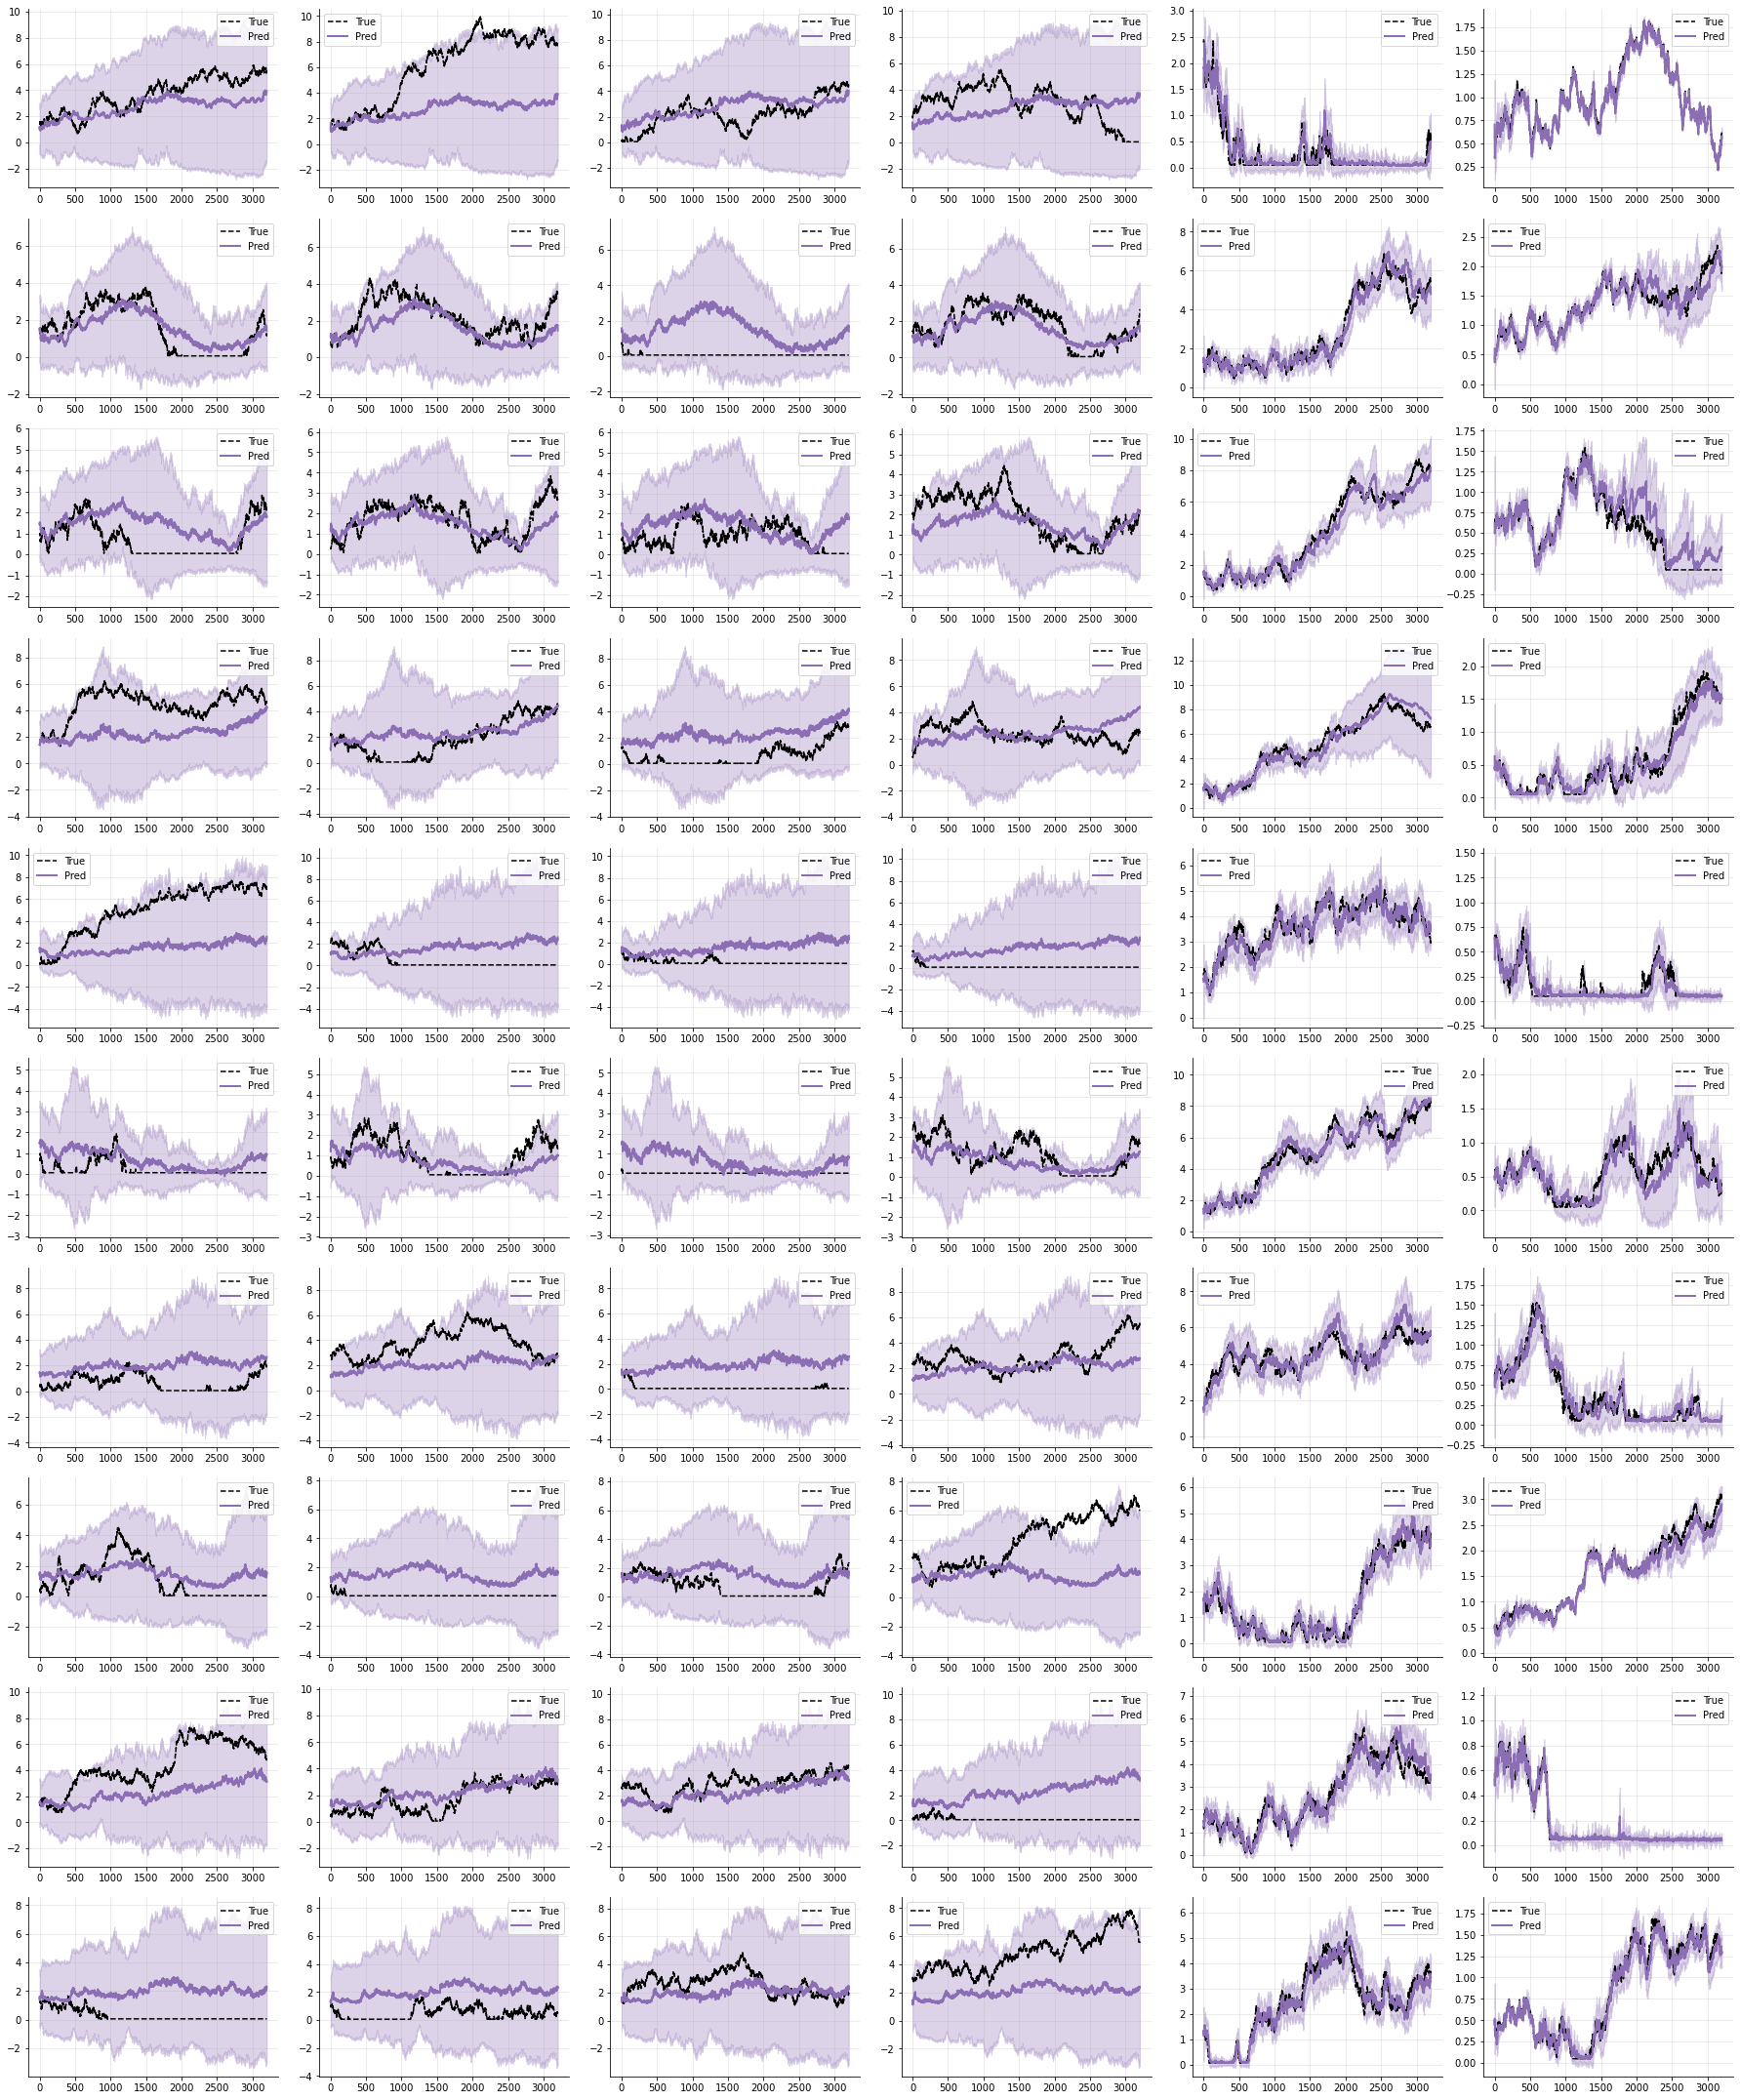

In [53]:
f, axarr = plt.subplots(TEST_SIZE, 6, figsize=(25, 30))
std_mul = 2
time = np.arange(1, theta_test.shape[1]+1)
for j in range(TEST_SIZE):
    for i in range(6):
        ax = axarr[j, i]
        ax.plot(time, theta_test[j, :, i], label='True', color='black', linestyle='dashed')
        ax.plot(time, theta_means[j, :, i], label='Pred', lw=2, color='#8c6eb5')
        ax.fill_between(time, 
                        theta_means[j, :, i] + std_mul * theta_stds[j, :, i], 
                        theta_means[j, :, i] - std_mul * theta_stds[j, :, i], color='#8c6eb5', alpha=0.3)
        sns.despine(ax=ax)
        ax.legend()
        ax.grid(alpha=0.3)
f.tight_layout()

## Visualize Slices

In [18]:
VAL_SIZE = 300
theta0 = diffusion_prior_gp(VAL_SIZE, n_cond=1)
eta = length_scale_prior(VAL_SIZE, 3)
theta_test = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES)
rt_test = simple_batch_diffusion(theta_test).astype(np.float32)
SLICE_POINTS = [2, 50, 100]

In [ ]:
theta_preds = network(rt_test)
theta_means = theta_preds.mean().numpy() * PARAMS_STD + PARAMS_MEAN
theta_stds = theta_preds.stddev().numpy() * PARAMS_STD

2022-10-19 08:14:32.691926: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB (rounded to 2457600000)requested by op CudnnRNN
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-10-19 08:14:32.703291: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2022-10-19 08:14:32.703309: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 298931, Chunks in use: 298929. 72.98MiB allocated for chunks. 72.98MiB in use in bin. 1.14MiB client-requested in use in bin.
2022-10-19 08:14:32.703314: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 7, Chunks in use: 6. 3.8KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2022-10-19 08:14:32.703

2022-10-IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

e 256 next 154666
2022-10-19 08:14:33.320110: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f61c7985f00 of size 256 next 154609
2022-10-19 08:14:33.320114: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f61c7986000 of size 256 next 154781
2022-10-19 08:14:33.320117: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f61c7986100 of size 256 next 154767
2022-10-19 08:14:33.320120: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f61c7986200 of size 256 next 154784
2022-10-19 08:14:33.320123: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f61c7986300 of size 256 next 154

In [ ]:
f, axarr = plt.subplots(len(SLICE_POINTS), 3, figsize=(10, 10))
for j in range(len(SLICE_POINTS)):
    for i in range(3):
        ax = axarr[j, i]
        true = theta_test[:, SLICE_POINTS[j]-1, i]
        pred = theta_means[:, SLICE_POINTS[j]-1, i]
        std = theta_stds[:, SLICE_POINTS[j]-1, i]
        ax.errorbar(true, pred, yerr=std, fmt='o', alpha=0.5, color='#8c6eb5')
        # ax.scatter(true, pred, color='#8c6eb5')
        sns.despine(ax=ax)
        ax.grid(alpha=0.3)
        
        lower = min(true.min(), pred.min())
        upper = max(true.max(), pred.max())
        eps = (upper - lower) * 0.1
        ax.set_xlim([lower - eps, upper + eps])
        ax.set_ylim([lower - eps, upper + eps]) 
        ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_ylim()[0], ax.get_ylim()[1]], 
                 color='black', alpha=0.9, linestyle='dashed')
        ax.set_xlabel('True')
        ax.set_ylabel('Estimated mean')
        if i == 0:
            ax.text(-0.5, 0.5, f'T={SLICE_POINTS[j]}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
f.tight_layout()